# Creating a SDM grid
This Notebook creates a grid indicating suitability of habitat from a species distribution model.

We use three genetic subpopulations of *Placopecten magellanicus* according to three different species distribution models, one for each subpopulation. The suitability over the whole domain for each subpopulation must be distinctly mapped.

In [1]:
import pickle
import sys
from pathlib import Path

import rasterio as rs
import numpy as np
from rasterio.plot import show
from IPython.core.display import display

sys.path.insert(1, str(Path.cwd() / 'utils'))
from geneticlineage import GeneticLineage  # noqa: E402
from zone import Zone  # noqa: E402

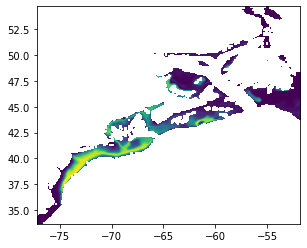

BoundingBox(left=-77.25509557699999, bottom=33.690644312, right=-51.82509557699999, top=54.690644312)
shape: (2100, 2543)


In [2]:
# Read probabilistic SDM
with rs.open(Path.cwd() / 'data' / 'sdm' / 'scallop_mosaic.tif') as sdm:
    show(sdm)
    
    probability = sdm.read(1)
    RES, _ = sdm.res
    
    bound = sdm.bounds
    print(bound)
    
    lon_cells = np.arange(bound.left + RES, bound.right, RES)
    lat_cells = np.arange(bound.top - RES, bound.bottom, -RES)
    
    print(f'shape: {sdm.shape}')

In [3]:
# Define genetic zone characteristics
path = Path.cwd() / 'data' / 'zones'
zones = {
    Zone.SOUTH: GeneticLineage.from_file(Zone.SOUTH, 0.42, path / f'{Zone.SOUTH.name}.txt'),
    Zone.NORTH_GSL: GeneticLineage.from_file(Zone.NORTH_GSL, 0.25, path / f'{Zone.NORTH_GSL.name}.txt'),
    Zone.NORTH_NL: GeneticLineage.from_file(Zone.NORTH_NL, 0.63, path / f'{Zone.NORTH_NL.name}.txt'),
}

In [4]:
lon_index = dict((lon, i) for i, lon in enumerate(lon_cells))
lat_index = dict((lat, i) for i, lat in enumerate(lat_cells))


def get_cell_suitability(genetic_zone: GeneticLineage, lon: float, lat: float) -> int:
    """Determine if a cell is suitable habitat."""
    if genetic_zone.contains(lon, lat):
        # Within spawn region
        if probability[lat_index[lat], lon_index[lon]] >= genetic_zone.prob:
            # Habitat is suitable
            return 1
        else:
            # Habitat is unsuitable
            return 0
    else:
        # Outside of spawn region
        return 0


lons, lats = list(zip(*[(lon, lat) for lat in lat_cells for lon in lon_cells]))
for zone in zones.values():
    codes = [get_cell_suitability(zone, lon, lat) for lon, lat in zip(lons, lats)]
    zone.associate_sdm(codes, lons, lats)

In [5]:
display(zones[Zone.SOUTH].sdm)

with open(Path.cwd() / 'data' / 'zones' / 'zones.pickle', 'wb') as file:
    pickle.dump(zones, file, protocol=pickle.HIGHEST_PROTOCOL)

,code,lon,lat
0,0,-77.245096,54.680644
1,0,-77.235096,54.680644
2,0,-77.225096,54.680644
3,0,-77.215096,54.680644
4,0,-77.205096,54.680644
...,...,...,...
5335653,0,-51.875096,33.700644
5335654,0,-51.865096,33.700644
5335655,0,-51.855096,33.700644
5335656,0,-51.845096,33.700644
